✅ Data uploaded to Neo4j.


C:\Users\Asmaa Ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


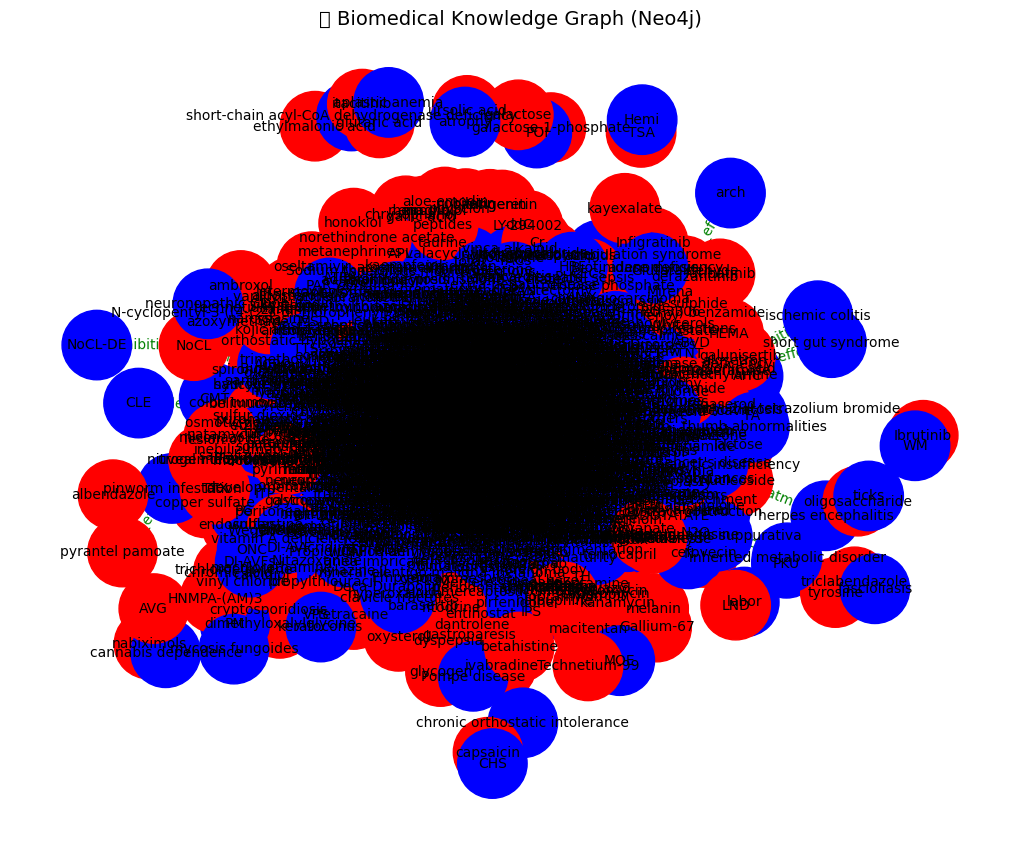

In [ ]:
from py2neo import Graph, Node, Relationship
import json
import networkx as nx
import matplotlib.pyplot as plt

# 🔗 Connect to Neo4j (update credentials if needed)
graph = Graph("neo4j://<HOST>:<PORT>", auth=("<USERNAME>", "<PASSWORD>"))
graph.delete_all()  # Optional: clear old data

# 📄 Sample JSON data (you can load from file too)
with open(".\data\steps data output\step-5\biobert_disease_chemical_relations.json", "r") as f:
    data = json.load(f)  # not f.read()
# 🔁 Load data into Neo4j
for item in data:
    pmid = item["pmid"]
    sentence = item["sentence"]

    chem = item["chemical"]
    dis = item["disease"]
    rel = item["relation_info"]

    # Create or merge nodes
    chem_node = Node("Chemical", name=chem["name"], identifier=chem["identifier"])
    dis_node = Node("Disease", name=dis["name"], identifier=dis["identifier"])

    graph.merge(chem_node, "Chemical", "identifier")
    graph.merge(dis_node, "Disease", "identifier")

    # Create or merge relation
    relation = Relationship(
        chem_node, rel["relation_type"], dis_node,
        phrase=rel["relation_phrase"],
        similarity=float(rel["similarity_score"]),
        pmid=pmid,
        sentence=sentence
    )

    graph.merge(relation)

print("✅ Data uploaded to Neo4j.")

# 📊 Query data from Neo4j
query = """
MATCH (c:Chemical)-[r]->(d:Disease)
RETURN c.name AS chemical, d.name AS disease, type(r) AS relation
"""

results = graph.run(query).data()

# 🧠 Visualize as Knowledge Graph in Jupyter
G = nx.DiGraph()

for row in results:
    G.add_node(row['chemical'], color='red')
    G.add_node(row['disease'], color='blue')
    G.add_edge(row['chemical'], row['disease'], label=row['relation'])

pos = nx.spring_layout(G, k=0.5)
colors = [G.nodes[n]['color'] for n in G.nodes]
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2500, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')
plt.title("🧬 Biomedical Knowledge Graph (Neo4j)", fontsize=14)
plt.show()


✅ All biomedical relationships uploaded to Neo4j.


C:\Users\Asmaa Ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


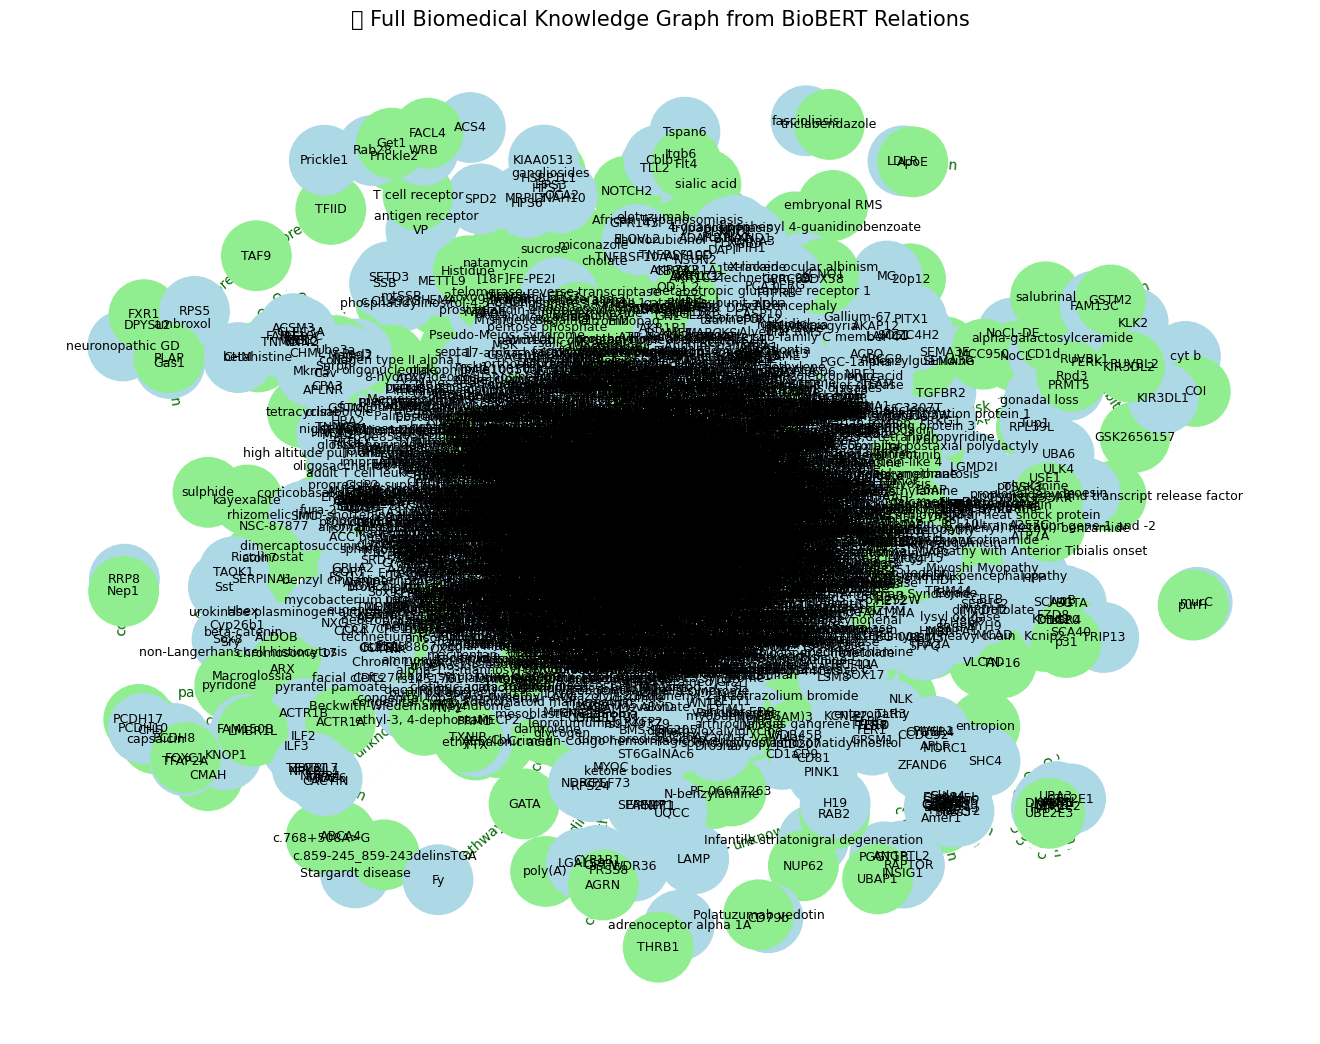

In [ ]:
from py2neo import Graph, Node, Relationship
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

# 🔗 Connect to Neo4j
graph = Graph("neo4j://<HOST>:<PORT>", auth=("<USERNAME>", "<PASSWORD>"))
graph.delete_all()

# 📁 Folder with multiple relation JSON files
input_folder = ".\data\steps data output\step-6\"

# 🔁 Process each file in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".json"):
        filepath = os.path.join(input_folder, filename)
        with open(filepath, "r") as f:
            data = json.load(f)

        for item in data:
            pmid = item["pmid"]
            sentence = item["sentence"]
            # Must contain 'entity1' and 'entity2'
            entity1 = item["entity1"]
            entity2 = item["entity2"]
            rel = item["relation_info"]

            # Create nodes with their dynamic labels
            node1 = Node(entity1["type"], name=entity1["name"], identifier=entity1["identifier"])
            node2 = Node(entity2["type"], name=entity2["name"], identifier=entity2["identifier"])

            graph.merge(node1, entity1["type"], "identifier")
            graph.merge(node2, entity2["type"], "identifier")

            # Create relationship
            relationship = Relationship(
                node1, rel["relation_type"], node2,
                phrase=rel["relation_phrase"],
                similarity=float(rel["similarity_score"]),
                pmid=pmid,
                sentence=sentence
            )
            graph.merge(relationship)

print("✅ All biomedical relationships uploaded to Neo4j.")

# 📊 Cypher query for all relationships
query = """
MATCH (a)-[r]->(b)
RETURN a.name AS source, labels(a)[0] AS source_type,
       b.name AS target, labels(b)[0] AS target_type,
       type(r) AS relation
"""
results = graph.run(query).data()

# 🧠 Visualize full knowledge graph
G = nx.DiGraph()

for row in results:
    G.add_node(row['source'], label=row['source_type'], color='lightblue')
    G.add_node(row['target'], label=row['target_type'], color='lightgreen')
    G.add_edge(row['source'], row['target'], label=row['relation'])

pos = nx.spring_layout(G, k=0.6)
colors = [G.nodes[n]['color'] for n in G.nodes]
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(13, 10))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2500, font_size=9)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkgreen')
plt.title("🧠 Full Biomedical Knowledge Graph from BioBERT Relations", fontsize=15)
plt.show()

In [ ]:
import os
import json

# 🔁 Source folder containing original JSON files
input_folder = ".\data\steps data output\step-5\"
output_folder = ".\data\steps data output\step-6\"
os.makedirs(output_folder, exist_ok=True)

# 🧠 List of all possible biomedical entity types you may have
entity_types = ["disease", "chemical", "gene", "variant", "chromosome", "phenotype","gene1","gene2","disease1","disease2"]

# 🔄 Process each file
for filename in os.listdir(input_folder):
    if not filename.endswith(".json"):
        continue

    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    with open(input_path, "r") as infile:
        try:
            data = json.load(infile)
        except json.JSONDecodeError:
            print(f"❌ Skipping invalid JSON file: {filename}")
            continue

    converted = []
    for entry in data:
        # Detect the two entity types in the entry
        entities_found = [key for key in entry if key in entity_types]
        if len(entities_found) != 2:
            print(f"⚠️ Skipping entry in {filename} (expected 2 entities, found {len(entities_found)})")
            continue

        e1_key, e2_key = entities_found
        e1 = entry[e1_key]
        e2 = entry[e2_key]

        converted_entry = {
            "entity1": {
                "name": e1["name"],
                "type": e1["type"],
                "identifier": e1["identifier"]
            },
            "entity2": {
                "name": e2["name"],
                "type": e2["type"],
                "identifier": e2["identifier"]
            },
            "relation_info": entry.get("relation_info", {}),
            "pmid": entry.get("pmid", ""),
            "sentence": entry.get("sentence", "")
        }

        converted.append(converted_entry)

    # ✅ Write converted output
    with open(output_path, "w") as outfile:
        json.dump(converted, outfile, indent=2)

    print(f"✅ Converted {filename} → {output_path}")


✅ Converted biobert_disease_chemical_relations.json → ./converted_relations/biobert_disease_chemical_relations.json
✅ Converted biobert_disease_chromosome_relations.json → ./converted_relations/biobert_disease_chromosome_relations.json
✅ Converted biobert_disease_disease_relations.json → ./converted_relations/biobert_disease_disease_relations.json
✅ Converted biobert_disease_gene_relations.json → ./converted_relations/biobert_disease_gene_relations.json
✅ Converted biobert_disease_variant_relations.json → ./converted_relations/biobert_disease_variant_relations.json
✅ Converted biobert_gene_chemical_relations.json → ./converted_relations/biobert_gene_chemical_relations.json
✅ Converted biobert_gene_chromosome_relations.json → ./converted_relations/biobert_gene_chromosome_relations.json
✅ Converted biobert_gene_gene_relations.json → ./converted_relations/biobert_gene_gene_relations.json
✅ Converted biobert_gene_variant_relations.json → ./converted_relations/biobert_gene_variant_relations

In [ ]:
# %pip install yfiles_jupyter_graphs --quiet
# %pip install neo4j --quiet
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget

In [ ]:
from py2neo import Graph, Node, Relationship
import json
import networkx as nx
import matplotlib.pyplot as plt

# 🔗 Connect to Neo4j (update credentials if needed)
graph = Graph("neo4j://<HOST>:<PORT>", auth=("<USERNAME>", "<PASSWORD>"))
graph.delete_all()  # Optional: clear old data

# 📄 Sample JSON data (you can load from file too)
with open(".\data\steps data output\step-6\biobert_disease_disease_relations.json", "r") as f:
    data = json.load(f)  # not f.read()
# 🔁 Load data into Neo4j
for item in data:
    pmid = item.get("pmid")
    sentence = item.get("sentence", "")    
    e1 = item["entity1"]
    e2 = item["entity2"]
    rel = item["relation_info"]
    # Create nodes
    node1 = Node(e1["type"], name=e1["name"], identifier=e1["identifier"])
    node2 = Node(e2["type"], name=e2["name"], identifier=e2["identifier"])    
    graph.merge(node1, e1["type"], "name")
    graph.merge(node2, e2["type"], "name")    # Create relationship
    relationship = Relationship(
    node1,
    rel["relation_type"],
    node2,
    phrase=rel.get("relation_phrase", ""),
    similarity=float(rel.get("similarity_score", 0)),
    pmid=pmid,
    sentence=sentence
    )

    graph.merge(relationship)

print("✅ Data uploaded to Neo4j.")

✅ Data uploaded to Neo4j.


In [ ]:
from py2neo import Graph
graph = Graph("neo4j://<HOST>:<PORT>", auth=("<USERNAME>", "<PASSWORD>"))
total_nodes = graph.evaluate("MATCH (n) RETURN count(n)")
total_edges = graph.evaluate("MATCH ()-[r]->() RETURN count(r)")
print(f"Total Nodes: {total_nodes}")
print(f"Total Relationships (Edges): {total_edges}")


Total Nodes: 15072
Total Relationships (Edges): 53910


In [33]:
from py2neo import Graph

# Connect to Neo4j
graph = Graph("neo4j://localhost:7687", auth=("<USERNAME>", "<PASSWORD>"))

# Count total distinct Disease–Disease relationships once
unique_disease_disease_relationships = """
MATCH (d1:Disease)-[r]-(d2:Disease)
WHERE id(d1) < id(d2)
RETURN type(r) AS RelationType, count(r) AS Total
"""

# Execute and print
relation_counts = graph.run(unique_disease_disease_relationships).data()

print("🔗 Unique Disease–Disease Relationship Types (No Duplicates):")
for row in relation_counts:
    print(f"{row['RelationType']}: {row['Total']}")


🔗 Unique Disease–Disease Relationship Types (No Duplicates):
shared_risk: 31296
progression: 2984
differential: 423
unknown: 7528
comorbidity: 11678


In [ ]:
from py2neo import Graph, Node, Relationship
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

# 🔗 Connect to Neo4j
graph = Graph("neo4j://<HOST>:<PORT>", auth=("<USERNAME>", "<PASSWORD>"))
graph.delete_all()  # Optional: clear old data

# 📂 Folder containing all JSON files
data_folder = ".\data\steps data output\step-6\"

# 🎨 Color for visualization
color_map = {
    "Gene": "orange",
    "Disease": "red",
    "Chemical": "blue",
    "Variant": "brown",
    "Chromosome": "purple"
}

# 🔁 Loop through all files
for file in os.listdir(data_folder):
    if file.endswith(".json"):
        file_path = os.path.join(data_folder, file)
        with open(file_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"❌ Error reading {file}: {e}")
                continue

        for item in data:
            try:
                pmid = item.get("pmid")
                sentence = item.get("sentence", "")

                e1 = item["entity1"]
                e2 = item["entity2"]
                rel = item["relation_info"]

                # Create nodes
                node1 = Node(e1["type"], name=e1["name"], identifier=e1["identifier"])
                node2 = Node(e2["type"], name=e2["name"], identifier=e2["identifier"])

                graph.merge(node1, e1["type"], "name")
                graph.merge(node2, e2["type"], "name")

                # Create relationship
                relationship = Relationship(
                    node1,
                    rel["relation_type"],
                    node2,
                    phrase=rel.get("relation_phrase", ""),
                    similarity=float(rel.get("similarity_score", 0)),
                    pmid=pmid,
                    sentence=sentence
                )
                graph.merge(relationship)
            except Exception as e:
                print(f"⚠️ Skipping item in {file}: {e}")

print("✅ All entity types and files loaded into Neo4j.")


✅ All entity types and files loaded into Neo4j.


In [3]:
pip install py2neo


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install matplotlib


  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 405.0 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/8.1 MB 405.0 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/8.1 MB 405.0 kB/s eta 0:00:19


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install neo4j


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install yfiles-jupyter-graphs


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from py2neo import Graph, Node, Relationship
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
NEO4J_URI      = "neo4j://<HOST>:<PORT>"
NEO4J_USERNAME = "<USERNAME>"
NEO4J_PASSWORD = "<PASSWORD>"
# create a neo4j session to run queries
driver = GraphDatabase.driver(uri = NEO4J_URI, auth = (NEO4J_USERNAME, NEO4J_PASSWORD), database = 'neo4j')
session = driver.session()

# directly show the graph resulting from the given Cypher query
def showGraph(cypher: str):
    widget = GraphWidget(graph = session.run(cypher).graph())
    display(widget)
    return widget

In [ ]:
from py2neo import Graph
graph = Graph("neo4j://<HOST>:<PORT>", auth=("<USERNAME>", "<PASSWORD>"))

total_nodes = graph.evaluate("MATCH (n) RETURN count(n)")


total_edges = graph.evaluate("MATCH ()-[r]->() RETURN count(r)")

print(f"Total Nodes: {total_nodes}")
print(f"Total Relationships (Edges): {total_edges}")


Total Nodes: 21840
Total Relationships (Edges): 80736


In [ ]:
w = showGraph("MATCH (a)-[r]-(b) RETURN a, r, b")

GraphWidget(layout=Layout(height='800px', width='100%'))

In [ ]:
from py2neo import Graph
# Connect to Neo4j
graph = Graph("neo4j://localhost:7687", auth=("<USERNAME>", "<PASSWORD>"))
# 2. Count relationships between Gene and Disease
count_relationships_query = """
MATCH (g:Gene)-[r]-(d:Disease)
RETURN type(r) AS RelationType, count(r) AS Total
ORDER BY Total DESC
"""
relation_counts = graph.run(count_relationships_query).data()
print(".\n🔗 Gene-Disease Relationship Types (Descending):")
for row in relation_counts:
    print(f"{row['RelationType']}: {row['Total']}")



🔗 Gene-Disease Relationship Types (Descending):
susceptibility: 1954
causation: 931
association: 569
mutation: 314
expression: 288
unknown: 109


In [ ]:
from py2neo import Graph

# Connect to Neo4j
graph = Graph("neo4j://localhost:7687", auth=("<USERNAME>", "<PASSWORD>"))

# Unique Gene–Gene relationship count
unique_gene_gene_relationships = """
MATCH (g1:Gene)-[r]-(g2:Gene)
WHERE id(g1) < id(g2)
RETURN type(r) AS RelationType, count(r) AS Total
ORDER BY Total DESC
"""

# Run query and print results
relation_counts = graph.run(unique_gene_gene_relationships).data()

print("🔗 Unique Gene–Gene Relationship Types (No Duplicates):")
for row in relation_counts:
    print(f"{row['RelationType']}: {row['Total']}")


🔗 Unique Gene–Gene Relationship Types (No Duplicates):
coexpression: 4546
pathway: 1032
unknown: 1022
regulation: 303
genetic_link: 278
interaction: 93


In [ ]:
from py2neo import Graph

# Connect to Neo4j
graph = Graph("neo4j://localhost:7687", auth=("<USERNAME>", "<PASSWORD>"))

# 1. Count unique Disease nodes connected to variant
count_connected_genes = """
MATCH (d:Gene)-[]-(g:Variant)
RETURN 'Gene' AS Label, count(DISTINCT d) AS Total
"""

# 2. Count unique Variant nodes connected to genes
count_connected_Variant = """
MATCH (d:Gene)-[]-(g:Variant)
RETURN 'Variant' AS Label, count(DISTINCT g) AS Total
"""

# 3. Count total relationships between Gene and Disease
count_gene_variant_relationships = """
MATCH (d:Gene)-[r]-(g:Variant)
RETURN count(r) AS TotalRelations
"""

# Execute queries
gene_result = graph.run(count_connected_genes).data()[0]
variant_result = graph.run(count_connected_Variant).data()[0]
relation_result = graph.run(count_gene_variant_relationships).data()[0]

# Print results
print("🔗 Connected Gene-Variant Subgraph Summary:")
print(f"{gene_result['Label']} Nodes: {gene_result['Total']}")
print(f"{variant_result['Label']} Nodes: {variant_result['Total']}")
print(f"Total Gene-Variant Relationships: {relation_result['TotalRelations']}")

🔗 Connected Gene-Variant Subgraph Summary:
Gene Nodes: 77
Variant Nodes: 77
Total Gene-Variant Relationships: 136


In [ ]:
w = showGraph("MATCH (a)-[r]-(b) WHERE r.pmid ='35321276' RETURN a, r, b")

GraphWidget(layout=Layout(height='500px', width='100%'))

GraphWidget(layout=Layout(height='500px', width='100%'))

In [ ]:
w = showGraph("MATCH p=(n:Disease) -[r]->(m) WHERE n.name in ['ASPS','lentigo maligna melanoma','Ehlers-Danlos syndrome'] RETURN *")

NameError: name 'showGraph' is not defined

In [ ]:
w = showGraph("MATCH (d:Disease)-[r1:risk]->(v:Variant),(d)-[r2:side_effect]->(c:Chemical),(d)-[r3:mutation]->(g:Gene),(d)-[r4:deletion]->(ch:Chromosome) RETURN *")

GraphWidget(layout=Layout(height='800px', width='100%'))